# Rasterio and downscaling rasters

## Introduction

### Overview
This notebook is a re-implementation of the chapter in the book *Python Maps*, relating to global shipping. 

### Data Source
 The data I used came from [https://datacatalog.worldbank.org/search/dataset/0037580]



The recommended citation is:

_“Data source: IMF’s World Seaborne Trade monitoring system (Cerdeiro, Komaromi, Liu and Saeed, 2020).”_

This is a very large dataset (over 9 Gigabytes), and this blog post is largely about how to downscale  to handle very large rasters, so we can use GeoPandas

-----------------------

## Implementation

### Notebook Magics

`watermark` provides reproducability data, `lab_black` enforces a standard Python style

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

### Imports

All imports are here

In [3]:
import rasterio
import rasterio.plot as riop
import rasterio.mask as riom
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import geopandas as gpd
import shapely.geometry as sg

import cartopy.crs as ccrs
import cartopy

import numpy as np

--------------------

## Data Load

Use rasterio to examine the properties of the dataset

In [4]:
URL = (
    "C:\\Data\\PythonMaps\\Shipping\\shipdensity_global.tif"
)

src = rasterio.open(URL)

Let us see how big the raster is - not small!

In [5]:
src.shape

(33998, 72006)

Look as the Coordinate Reference System.  Good old Plate Carree.

In [6]:
src.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

Examine the extent of the raster: almost the whole globe

In [7]:
src.bounds

BoundingBox(left=-180.015311275, bottom=-84.98735206299992, right=180.01468872500004, top=85.00264793700009)

Examine the band count (expect only 1, and not disappointed:  we don't have any RGB bands)

In [8]:
src.count

1

---------

## Downscaling with rasterio


The approach we will take to to only take every n-th pixel (in x and y direction).  We do this by specifying an `out_shape`  parameter on the `read`.  We don't need any fancy interpolation, so specify `nearest` for the resampling (using exact integer downscale factor, so this should never be an issue)

In [9]:
upscale_factor = 1.0 / 64

data = src.read(
    out_shape=(
        src.count,
        int(src.height * upscale_factor),
        int(src.width * upscale_factor),
    ),
    resampling=Resampling.nearest,
)

Examine raster size (as read from disk), indeed 1/n size in X and Y direction

In [10]:
data.shape

(1, 531, 1125)

### Initial visualization

Do a quick and easy plot.  I set up my own color map, to enhance the image.  The plot serves to give an overview of the major global shipping channels.

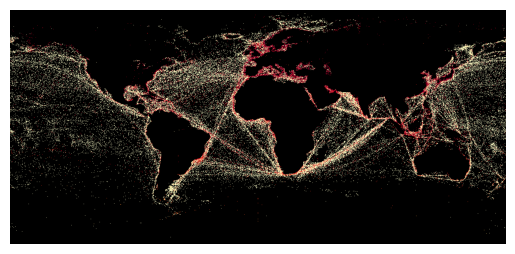

In [11]:
my_cmap = matplotlib.colormaps['YlOrRd']
my_cmap.set_bad(color='black')
my_cmap.set_under('black')


ax = plt.imshow(
    data[0], norm=colors.LogNorm(), cmap=my_cmap
)
ax.axes.set_axis_off()

Another view of my color map

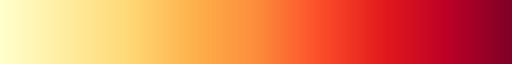

In [12]:
my_cmap

-----------------------------

### Convert to GeoDataFrame

`rasterio`  has a concept of a Transformer, that converts row, column indices into coordinates in the Coordinate Reference System for the array ( in our case, Latitude, Longitude values).

The original raster (before we downscaled it) has a Transformer defined, and we must adjust it for our downscaling before we can get Lat / Lon values


#### Transforms

We examine the original array transform.  We get a 3 wide by two deep matrix.  Conceptually, we multiply on the left by a three deep vertical vector [col, row, 1], to get the corresponding CRS coordinates of the pixel indexed by row, col.

In [13]:
src.transform

Affine(0.005, 0.0, -180.015311275,
       0.0, -0.005, 85.00264793700009)

I was  initially confused by the fact that the transform of the 0,0 pixel didn't match to the bounding box of the array,
but then realised (after reading the documentation) that I was being given the coordinates of the  __centre__ of the pixel

In [14]:
src.bounds

BoundingBox(left=-180.015311275, bottom=-84.98735206299992, right=180.01468872500004, top=85.00264793700009)

In [15]:
src.xy(0, 0)

(-180.012811275, 85.0001479370001)

Because the original array has a step of  0.005 degrees, 
half a pixel width is 0.0025, and this is exactly the offset of the 0,0 CRS coordinates from the bounding box border

#### Scaling a transform

Because we have downscaled, the original transform must be adjusted. The DataReader object we created by the `rasterio.open` call has a helper function `scale`, that creates a matrix (three wide, two deep) that when multiplied on the left, gives us a new transform, appropriate for the downscaling we specified.

Examine the scaling matrix.  Essentially because we downscaled by n, the step size array element to array element is n time larger than the original step size

In [16]:
src.transform.scale(
    src.width / data.shape[-1], src.height / data.shape[-2]
)

Affine(64.00533333333334, 0.0, 0.0,
       0.0, 64.02636534839925, 0.0)

Create a new transform from the original transform, and our downscaling factor

In [17]:
new_transform = src.transform * src.transform.scale(
    src.width / data.shape[-1], src.height / data.shape[-2]
)

In [18]:
new_transform

Affine(0.3200266666666667, 0.0, -180.015311275,
       0.0, -0.32013182674199625, 85.00264793700009)

Note that our step is now equal to 0.005 * n. The non-round numbers are probably due to the original array not being even multiples of n wide or deep.

We could have created this Affine object by hand (with a `rasterio.Affine` call), but chose to create it explicitly by `rasterio` calls

In [19]:
rasterio.Affine(
    0.3200266666666667,
    0.0,
    -180.015311275,
    0.0,
    -0.32013182674199625,
    85.00264793700009,
)

Affine(0.3200266666666667, 0.0, -180.015311275,
       0.0, -0.32013182674199625, 85.00264793700009)

#### Creating a scaled transformer

We can can create a new downscaled Transformer, taking as input our `new_transform`

This new Transformer Object will have the `xy` method that will convert our downscaled array coordindates (row, column) to our CRS coordinates

In [20]:
new_transformer = rasterio.transform.AffineTransformer(
    new_transform
)

Check our transformed coordinates have a step size of    (0.005 * n) degrees  in row and column direction

In [21]:
new_transformer.xy(0, 0)[1], new_transformer.xy(1, 0)[1]

(84.84258202362909, 84.52245019688709)

In [22]:
new_transformer.xy(0, 0)[0], new_transformer.xy(0, 1)[0]

(-179.85529794166666, -179.53527127499999)

----------------------

### Create GeoPandas GeoDataFrame


-----------------

#### Digression - meshgrid
How `meshgrid` works

In [23]:
# assume we have an array two deep, and three wide,
#  with rows indices [0,1], column indices [0, 1, 2]
# we want two lists c, r, such that c[i], r[i] for all i, gives the
# column, row coordinates of all array elements
c, r = np.meshgrid([0, 1, 2], [0, 1])
print(f'Column index list {c.flatten()}')
print(f'Row index list    {r.flatten()}')

Column index list [0 1 2 0 1 2]
Row index list    [0 0 0 1 1 1]


#### End of Digression

-----------------------------

We get the Row / Column arrays we want to use to get equivalent Lat / Lon arrays

Examine the size of our downscaled array: about 500,000 pixels (or data values)

In [24]:
data[0].shape

(531, 1125)

Get array indices

In [25]:
row_count, col_count = data[0].shape

col_indices, row_indices = np.meshgrid(
    np.arange(col_count), np.arange(row_count)
)
# flatten meshgrid output
col_indices = col_indices.flatten()
row_indices = row_indices.flatten()

Generate CRS coordinates of (downscaled) pixels

In [26]:
xs, ys = new_transformer.xy(row_indices, col_indices)

Check we have a step of 0.005*n degrees in Longitude direction

In [27]:
xs[0:10]

array([-179.85529794, -179.53527127, -179.21524461, -178.89521794,
       -178.57519127, -178.25516461, -177.93513794, -177.61511127,
       -177.29508461, -176.97505794])

#### Create a GeoPandas GeoDataFrame

In [28]:
# Create a DataFrame
df = pd.DataFrame(
    {'X': xs, 'Y': ys, 'value': data[0].flatten()}
)

gdf_scaled = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['X'], df['Y'])
)

Set the CRS of  the new GeoDataFrame: not really necessary in this case, but a good habit

In [29]:
gdf_scaled = gdf_scaled.set_crs('EPSG:4326')

In [30]:
gdf_scaled.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Check the initial and final values 

In [31]:
gdf_scaled.head(2)

,X,Y,value,geometry
0,-179.855298,84.842582,0,POINT (-179.8553 84.84258)
1,-179.535271,84.842582,0,POINT (-179.53527 84.84258)


In [32]:
gdf_scaled.tail(2)

,X,Y,value,geometry
597373,179.534649,-84.827286,0,POINT (179.53465 -84.82729)
597374,179.854675,-84.827286,0,POINT (179.85468 -84.82729)


#### Scale shipping density

In [33]:
t_start = pd.Timestamp('2015-01-01')
t_end = pd.Timestamp('2021-2-28')

t_duration = t_end - t_start

duration_days = t_duration.days
print(duration_days)

2250


GeoDataFrame now holds Average Daily AIS Location Report 

In [34]:
gdf_scaled['value'] = gdf_scaled['value'] / duration_days

Get approximate size of original pixel in kilometres.  The data we have is a sampling of original pixel values

In [35]:
km_per_degree = 110  # degree to Km (approx)
dataset_step = 0.005  # degrees


ais_box = dataset_step * km_per_degree

-----------------------

## Plot map

Text(0.5, 1.0, 'Shipping density: Average Daily AIS Location Reports from ~0.6Km squares (2015-2021)')

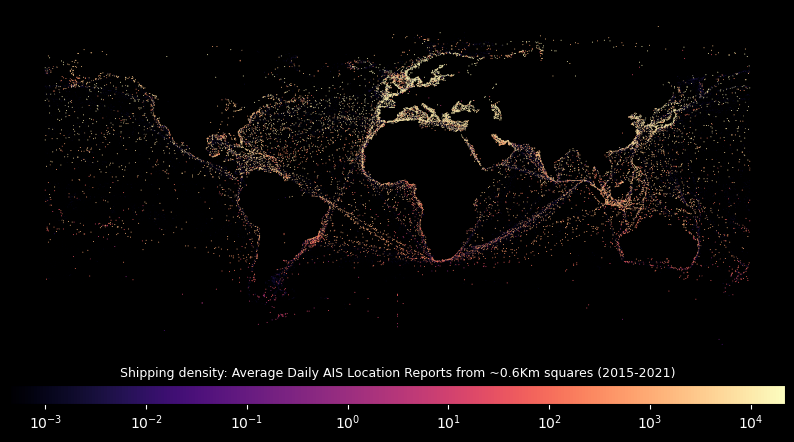

In [36]:
fig, ax = plt.subplots(
    facecolor='black',
    figsize=(10, 10),
)

# create a new Axes below the main graphic
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Plot via GeoPandas
gdf_scaled.plot(
    ax=ax,  # Axes for plot
    cax=cax,  # Axes for colorbar
    column='value',  # GeoDataFrame column to use to set color
    s=0.5,  # Size of marker
    cmap='magma',  # Colormap to use
    norm=colors.LogNorm(),  # value column varies widely, so use Log plot
    edgecolors='none',  # markers have no edges
    legend=True,  # create a colorbar
    legend_kwds={  # modify colorbar
        "shrink": 0.5,  # shrink from default size
        "location": "bottom",  # put at bottom of plot
        "orientation": "horizontal",  # make horizontal
    },
)
# suppress any plot x or axis text or ticks
ax.axis('off')

# set text of colorbar to be white, and set title
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=10, colors='white')
cb_ax.set_title(
    f'Shipping density: Average Daily AIS Location Reports from ~{ais_box:.1f}Km squares (2015-2021)',
    color='white',
    fontsize=9,
)

## Conclusions

Converting the raster to a GeoDataFrame made it a little more convenient to rescale the data, but I had to downscale by a large factor to get a manageable number of rows in the GeoDataFrame.

Looking at the results, I am surprised by the density of shipping with the Black and Caspian Seas. 


## Reproducibility information

In [37]:
%watermark

Last updated: 2025-05-07T09:36:18.216173+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [38]:
%watermark -co  -iv -v -h

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: pythonmaps

Hostname: INSPIRON16

matplotlib: 3.10.0
shapely   : 2.0.6
geopandas : 1.0.1
numpy     : 1.26.4
rasterio  : 1.4.3
pandas    : 2.2.3
cartopy   : 0.24.1

